In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem

In [5]:
#Read the datafiles to pandas dataframes
mousedata = pd.read_csv("mouse_drug_data.csv")
trialdata = pd.read_csv("clinicaltrial_data.csv")
print(mousedata).head()
print(trialdata).head()

    Mouse ID      Drug
0       f234  Stelasyn
1       x402  Stelasyn
2       a492  Stelasyn
3       w540  Stelasyn
4       v764  Stelasyn
5       o848  Stelasyn
6       z314  Stelasyn
7       g989  Stelasyn
8       m269  Stelasyn
9       a963  Stelasyn
10      t451  Stelasyn
11      p981  Stelasyn
12      k510  Stelasyn
13      h333  Stelasyn
14      c402  Stelasyn
15      j984  Stelasyn
16      w697  Stelasyn
17      s619  Stelasyn
18      g867  Stelasyn
19      k862  Stelasyn
20      i901  Stelasyn
21      b879  Stelasyn
22      p387  Stelasyn
23      a366  Stelasyn
24      s565  Stelasyn
25      j755  Naftisol
26      e213  Naftisol
27      e584  Naftisol
28      e291  Naftisol
29      z795  Naftisol
..       ...       ...
220     a444  Ramicane
221     a411  Ramicane
222     j913  Ramicane
223     q610  Ramicane
224     c458  Ramicane
225     a897   Placebo
226     c757   Placebo
227     i477   Placebo
228     o302   Placebo
229     t718   Placebo
230     w167   Placebo
231     x77

AttributeError: 'NoneType' object has no attribute 'head'

In [6]:
merged = pd.merge(mousedata, trialdata, on="Mouse ID")

merged = merged.set_index('Drug')
merged = merged.loc[['Capomulin','Infubinol','Ketapril','Placebo'],:]
merged.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
Drug,,,,
Capomulin,b128,0,45.000000,0
Capomulin,b128,5,45.651331,0
Capomulin,b128,10,43.270852,0
Capomulin,b128,15,43.784893,0
Capomulin,b128,20,42.731552,0


In [7]:
merged_pivot = merged.pivot_table(index=['Drug', 'Timepoint'],values=['Tumor Volume (mm3)','Metastatic Sites'],aggfunc=np.mean)
merged_pivot.head()

Metastatic Sites  Tumor Volume (mm3)
Drug      Timepoint                                      
Capomulin 0                  0.000000           45.000000
          5                  0.160000           44.266086
          10                 0.320000           43.084291
          15                 0.375000           42.064317
          20                 0.652174           40.716325

In [8]:
se = merged.pivot_table(index=['Drug', 'Timepoint'],values=['Tumor Volume (mm3)','Metastatic Sites'],aggfunc=sem)
se.head()

Metastatic Sites  Tumor Volume (mm3)
Drug      Timepoint                                      
Capomulin 0                  0.000000            0.000000
          5                  0.074833            0.448593
          10                 0.125433            0.702684
          15                 0.132048            0.838617
          20                 0.161621            0.909731

In [9]:
drug_index = merged_pivot.index.get_level_values(0).unique()
drug_index

Index(['Capomulin', 'Infubinol', 'Ketapril', 'Placebo'], dtype='object', name='Drug')

In [10]:
tumor_vol_change_list = []
for drug in drug_index:
    
    tumor_vol_t0 = merged_pivot.loc[drug].loc[0]['Tumor Volume (mm3)']
    
    num_timepoints = len(merged_pivot.loc[drug]['Tumor Volume (mm3)'].index)
    
    for i in range(num_timepoints):
        
        tp = 5*i
        
        tumor_vol_tp = merged_pivot.loc[drug].loc[tp]['Tumor Volume (mm3)']
        
        tumor_vol_change = (tumor_vol_tp-tumor_vol_t0)/tumor_vol_t0*100
        
        tumor_vol_change_list.append(tumor_vol_change)

#Convert the tumor change list to dataframe
tumor_vol_change_df = pd.DataFrame({"Tumor Volume Change (%)":tumor_vol_change_list}, index = merged_pivot.index)
tumor_vol_change_df.head()

Tumor Volume Change (%)
Drug      Timepoint                         
Capomulin 0                         0.000000
          5                        -1.630919
          10                       -4.257132
          15                       -6.523739
          20                       -9.519277

In [11]:
tumor_vol_d1 = merged_pivot.loc['Capomulin']['Tumor Volume (mm3)']

for drug in drug_index[1:]:
    
    tumor_vol_dx = merged_pivot.loc[drug]['Tumor Volume (mm3)']
    
    tumor_vol_dall = pd.concat([tumor_vol_d1,tumor_vol_dx], axis=1) 
    
    tumor_vol_d1=tumor_vol_dall


tumor_vol_dall.columns = drug_index

tumor_vol_dall.head()

Drug,Capomulin,Infubinol,Ketapril,Placebo
Timepoint,,,,
0,45.000000,45.000000,45.000000,45.000000
5,44.266086,47.062001,47.389175,47.125589
10,43.084291,49.403909,49.582269,49.423329
15,42.064317,51.296397,52.399974,51.359742
20,40.716325,53.197691,54.920935,54.364417


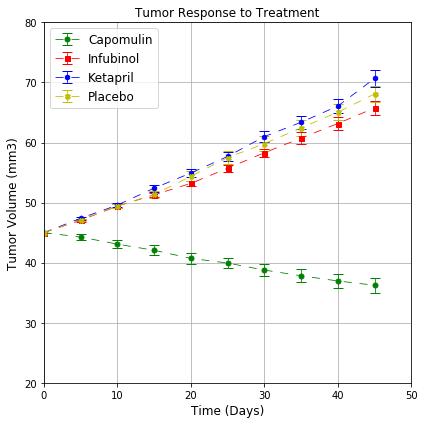

In [13]:
x_axis = tumor_vol_dall.index

color_panel = ['g','r','b','y','r','g','b','y','r','g']
filled_markers = ['o', 's', 'h', 'X', '>', '^', 'v', 'p', '*', '8', 'H', 'D', 'd', 'P', '<']

plt.figure(figsize=(6,6))

for i,drug in enumerate (drug_index):
    
    y_axis = tumor_vol_dall[drug]
    
    (_,caps,_)=plt.errorbar(x_axis, y_axis, yerr=se.loc[drug]['Tumor Volume (mm3)'], 
                 c=color_panel[i], marker=filled_markers[i], markersize=5, capsize=5, dashes=[10,10], linewidth=0.8)
    for cap in caps:
        cap.set_markeredgewidth(1)

plt.xlim(0, max(x_axis)+5)
plt.ylim(20, 80)

plt.title("Tumor Response to Treatment", fontsize=12)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("Tumor Volume (mm3)", fontsize=12)
plt.legend(drug_index, loc='best', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
plt.savefig('tumor_response')

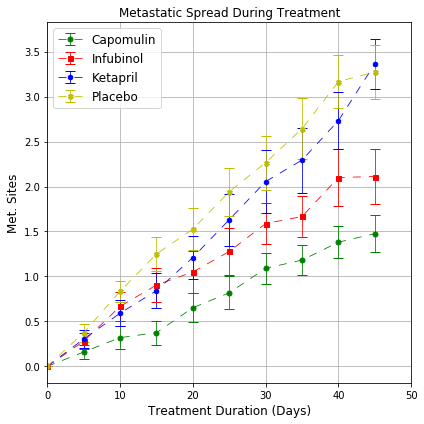

In [15]:
x_axis = tumor_vol_dall.index

color_panel=['g','r','b','y','r','g','b','y','r','g']
filled_markers = ['o', 's', 'h', 'X', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

plt.figure(figsize=(6,6))

for i,drug in enumerate (drug_index):
    (_,caps,_)=plt.errorbar(x_axis, merged_pivot.loc[drug,'Metastatic Sites'], yerr = se.loc[drug]['Metastatic Sites'], 
                 color=color_panel[i], fmt=filled_markers[i], capsize=5, markersize=5, dashes=[10,10], linewidth=0.8)
    for cap in caps:
        cap.set_markeredgewidth(1)
        
plt.xlim(0, max(x_axis)+5)


plt.title("Metastatic Spread During Treatment",fontsize=12)
plt.xlabel("Treatment Duration (Days)",fontsize=12)
plt.ylabel("Met. Sites",fontsize=12)
plt.legend(drug_index, loc='best', fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
survival_count = merged.groupby(["Drug","Timepoint"])['Tumor Volume (mm3)'].count()
survival_count.head()

Drug       Timepoint
Capomulin  0            25
           5            25
           10           25
           15           24
           20           23
Name: Tumor Volume (mm3), dtype: int64

In [17]:
survival_d1 = survival_count['Capomulin']

for drug in drug_index[1:]:
    survival_dx = survival_count[drug]
    survival_summary = pd.concat([survival_d1,survival_dx], axis=1) 
    survival_d1 = survival_summary

survival_summary.columns=drug_index

survival_summary.head()

Drug,Capomulin,Infubinol,Ketapril,Placebo
Timepoint,,,,
0,25,25,25,25
5,25,25,23,24
10,25,21,22,24
15,24,21,19,20
20,23,20,19,19


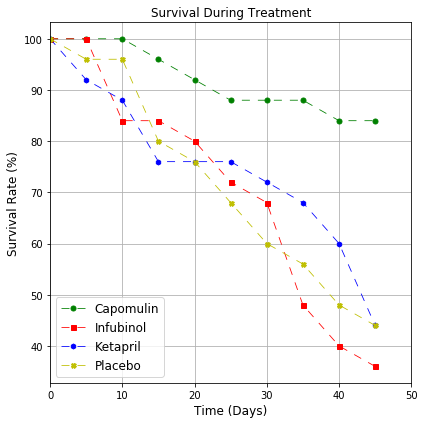

In [18]:
plt.figure(figsize=(6,6))

x_axis = survival_summary.index

color_panel = ['g','r','b','y','r','g','b','y','r','g']
filled_markers = ['o', 's', 'h', 'X', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

for i,drug in enumerate (drug_index):
    
    num_t0 = survival_summary[drug][0]
    
    plt.plot(x_axis,survival_summary[drug]/num_t0*100, marker = filled_markers[i], markersize = 5, c = color_panel[i],
             dashes=[10,10], linewidth=0.8)

plt.xlim(0, max(x_axis)+5)

plt.title("Survival During Treatment",fontsize=12)
plt.xlabel("Time (Days)",fontsize=12)
plt.ylabel("Survival Rate (%)",fontsize=12)
plt.legend(drug_index, loc='best',fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
summary=(tumor_vol_dall.loc[45]/tumor_vol_dall.loc[0]-1)*100
summary.head()

Drug
Capomulin   -19.475303
Infubinol    46.123472
Ketapril     57.028795
Placebo      51.297960
dtype: float64

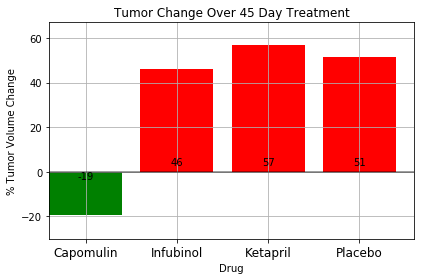

In [20]:
x_axis = np.arange(len(summary.index))
y_axis = summary.values

tick_locations = [value+0.4 for value in x_axis]

fig, ax = plt.subplots()

ax.hlines(0,0,len(x_axis), alpha=0.5)

for i,y in enumerate (y_axis):
    
    if y<0:
        rects=ax.bar(x_axis[i], y, color='g', alpha=1, align="edge")
    else:
        rects=ax.bar(x_axis[i], y, color='r', alpha=1, align="edge")
    
    for r in rects: 
        height = r.get_height()
        if height > 0:
            ax.text(r.get_x() + r.get_width()/2., 2,'%d' % int(height),ha='center', va='bottom')
        else:
            ax.text(r.get_x() + r.get_width()/2., -4,'%d' % int(height),ha='center', va='bottom')

plt.xticks(tick_locations, summary.index, rotation="horizontal", fontsize=12)

plt.xlim(0, len(x_axis))
plt.ylim(-30, max(y_axis)+10)

plt.title("Tumor Change Over 45 Day Treatment")
plt.xlabel("Drug")
plt.ylabel("% Tumor Volume Change")
plt.grid(True)

plt.tight_layout()
plt.show()
